In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
using DataFrames,CSV;
import NLsolve,Roots;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
mJψ+mω

3.87955

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:
qon_0(E)=xsqrt(2*μf(mDn,mDsn)*(E-mDn-mDsn))
qon_c(E)=xsqrt(2*μf(mDc,mDsc)*(E-mDc-mDsc))

qon_c (generic function with 1 method)

In [5]:
qon_0(mDn+mDsn-40e-6)|>println
qon_c(mDn+mDsn-40e-6)|>println

0.0 + 0.008793726405604092im
0.0 + 0.12619552252753702im


In [6]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

# VGT

In [7]:
function getqw(E,Λ;rs=1,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E)*(-1)^(rs+1),qon_c(E)
    for i in eachindex(xxx)
        qi[i+2]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [7]:
getqw(mDn+mDsn-40e-6,0.6;rs=1)

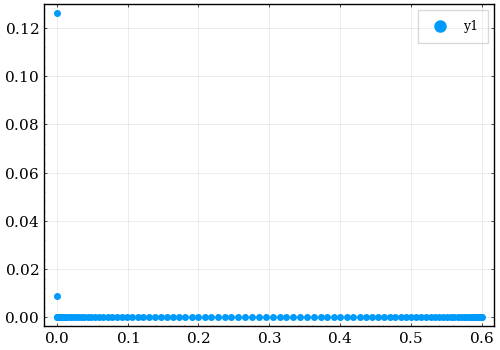

In [8]:
scatter(real.(qi[1:end]),imag.(qi[1:end]))

In [8]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [9]:
function VMat!(E;rs=1,Λ=0.5,C=1,Cv = 0.0,Cp=0.0,isπ=false,plist=qi,des=Vmat)
    getqw(E,Λ;rs=rs)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xn(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m]; C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xc(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

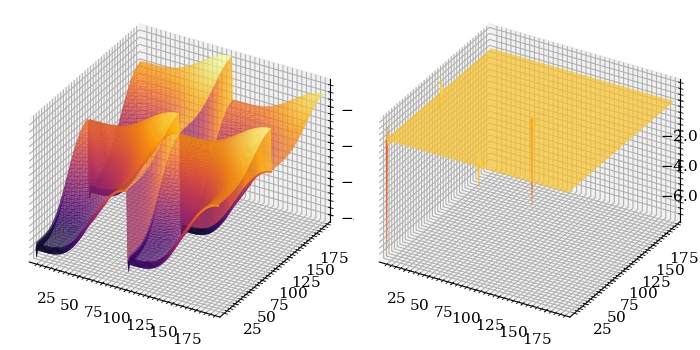

In [12]:
VMat!(3.87165;isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

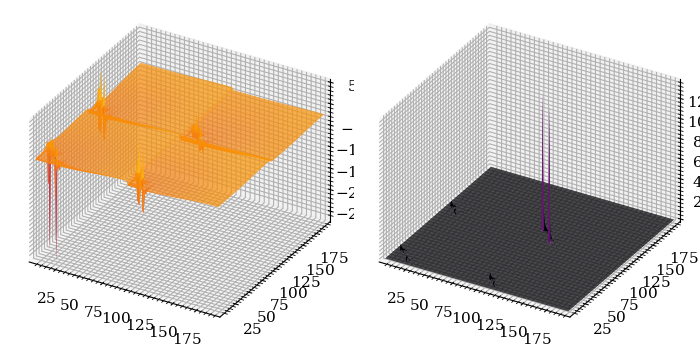

In [13]:
VMat!(3.87165;isπ=true)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [10]:
Gc(E,q)=1/(2π^2)/(E-mDc-mDsc-q^2/(2*μf(mDc,mDsc)))
Gn(E,q)=1/(2π^2)/(E-mDn-mDsn-q^2/(2*μf(mDn,mDsn)))

Gn (generic function with 1 method)

In [11]:
function GMat!(E;rs=1,Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ;rs=rs)
    μ1,μ2=μf(mDn,mDsn),μf(mDc,mDsc)
    k1,k2=qi[1],qi[2]
    
    tmp=zero(ComplexF64)
    
    for j in eachindex(wi)
        des[2+j,2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
        tmp+=-wi[j]*k1^2*Gn(E,qi[2+j])
    end
    des[1,1]=tmp+μ1*k1/(2π^2)*(log((Λ+k1)/(Λ-k1))-im*π)
    
    tmp=0.0+0.0im
    for j in eachindex(wi)
        des[sublen+2+j,sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
        tmp+=-wi[j]*k2^2*Gc(E,qi[2+j])
    end
    des[2+sublen,2+sublen]=tmp+μ2*k2/(2π^2)*(log((Λ+k2)/(Λ-k2))-im*π)
    
    return nothing
end

GMat! (generic function with 1 method)

In [12]:
function detVG(E;rs=1,Λ=0.5,Cv = 0.0,Cp=0.0,C=1,isπ=false)
    VMat!(E;rs=rs,Λ=Λ,Cv=Cv,Cp=Cp,C=C,isπ=isπ)
    GMat!(E;rs=rs,Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [13]:
function TMat!(E;rs=1,Λ=0.5,Cv = 0.0,Cp=0.0,C=1,des=Tmat,isπ=false)
    VMat!(E;rs=rs,Λ=Λ,Cv=Cv,Cp=Cp,C=C,isπ=isπ)
    GMat!(E;rs=rs,Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [18]:
@btime TMat!(3.87165)

  11.713 ms (1368 allocations: 2.56 MiB)


# Extract pole position

In [14]:
function find_poles(pars;C=1)
    _rs,_lam,_cv,_cp=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ;rs=_rs,C=C, Λ = _lam,Cv=_cv,Cp=_cp)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsn - 40e-6, 0])
#     println((tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2])
#     tmp
    return tmp.residual_norm <1e-8 ? (tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2] : NaN+im*NaN
end

find_poles (generic function with 1 method)

In [15]:
function isplus(pars;C=1)
    _rs,_lam,_cv,_cp=pars 
    pole=find_poles([_rs,_lam,_cv,_cp];C=C)
    if isnan(pole)
        return 0
    end
    
    TMat!(mDn+mDsn+pole;rs=_rs,Λ=_lam,Cv=_cv,Cp=_cp,C=C)
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    tmp1,tmp2=det(LinearAlgebra.I-v11*g11-v12*g22),det(LinearAlgebra.I-v11*g11+v12*g22)
    return abs(tmp1)<abs(tmp2) ? 1 : -1
end

isplus (generic function with 1 method)

## C=+

In [20]:
find_poles([1,0.35,0.0,0.0])

-0.011284198251838351 - 9.149908577617217e-21im

In [22]:
find_poles([1,0.35,0.95,0.0])

-0.00012504226705889465 - 9.481391744588482e-20im

In [21]:
find_poles([1,0.4,0.06,0.53])

-0.0193846959447459 + 3.474695204871895e-18im

In [44]:
find_poles([2,0.35,0.0,0.0])

NaN + NaN*im

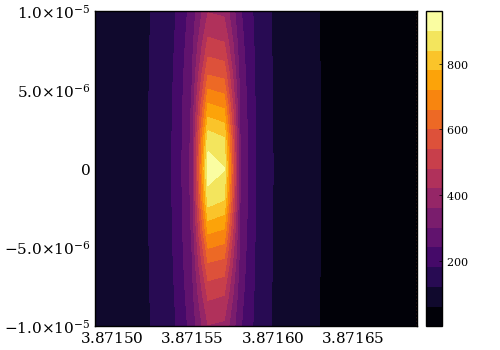

In [27]:
let Ev=collect(mDn+mDsn-200e-6:10e-6:mDn+mDsn),Γv=collect(-10e-6:2e-6:10e-6)
    resv=[1/abs(detVG(e+im*γ;rs=1,Λ=0.35,Cv=0.95,Cp=0.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsn],ls=:dot,label=false)
end

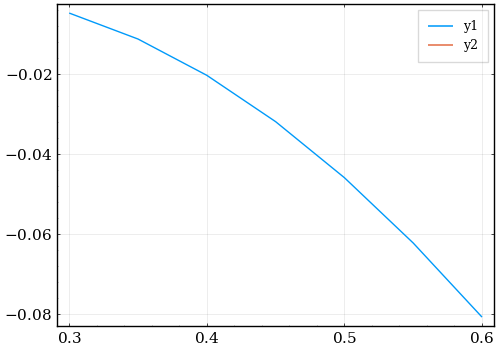

In [26]:
let Λv=0.3:0.05:0.6
    resv_rs1=[find_poles([1,λ,0.0,0.0]) for λ in Λv]
    resv_rs2=[find_poles([2,λ,0.0,0.0]) for λ in Λv]
    plot(Λv,real.(resv_rs1))
    plot!(Λv,real.(resv_rs2))
end

In [63]:
let Λv=collect(0.3:0.05:0.6),Cv_v=collect(0.0:0.1:1.0)
    global poles_rs1_CP=[find_poles([1,λ,c,0.0]) for c in Cv_v,λ in Λv]
    global poles_rs2_CP=[find_poles([2,λ,c,0.0]) for c in Cv_v,λ in Λv]
end

11×7 Matrix{ComplexF64}:
          NaN+NaN*im         …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im         …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
          NaN+NaN*im            NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
  -7.37465e-5+7.71513e-21im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 -0.000418746-3.29246e-18im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im

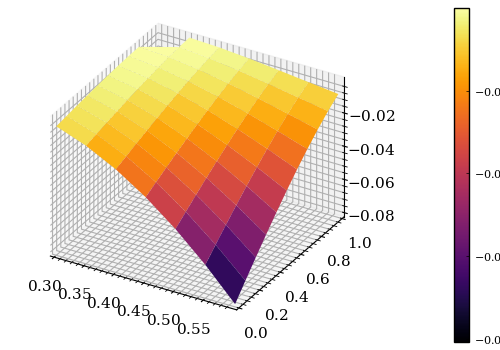

In [64]:
surface(0.3:0.05:0.6,0.0:0.1:1.0,real.(poles_rs1_CP))

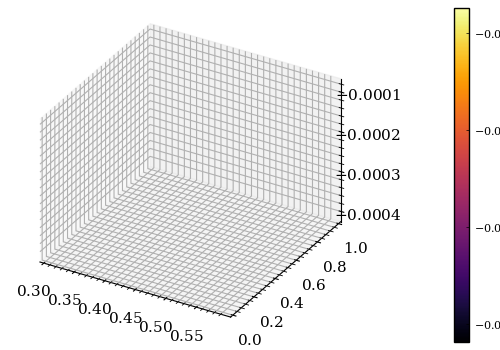

In [65]:
surface(0.3:0.05:0.6,0.0:0.1:1.0,real.(poles_rs2_CP))

## verify isospin by comparing |A-B| and |A+B|

In [35]:
find_poles([1,0.35,0.0,0.0])

-0.011284198251838351 - 9.149908577617217e-21im

In [36]:
TMat!(mDn+mDsc-0.011284198251838351 - 9.149908577617217e-21im;Λ=0.35)

In [37]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11-v12*g22)
end

-0.11024898211094385 - 2.4823019084007853e-17im

In [38]:
let
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    det(LinearAlgebra.I-v11*g11+v12*g22)
end

0.8318847758679555 + 1.3003397718458288e-17im

In [54]:
isplus([1,0.35,0.0,0.0])

1

**Thus, the pole corresponds to I=0,C=+**

## C=-

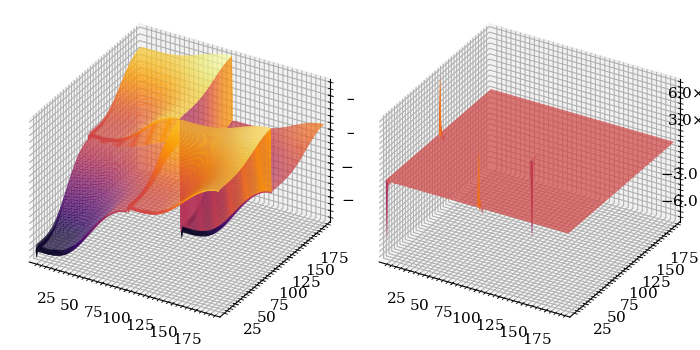

In [55]:
VMat!(3.87165;C=-1,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [56]:
find_poles([1,0.35,0.0,0.0];C=-1)

NaN + NaN*im

In [57]:
find_poles([2,0.35,0.0,0.0];C=-1)

-0.016504544309658087 - 2.5312748551958576e-18im

In [58]:
isplus([2,0.35,0.0,0.0];C=-1)

1

In [59]:
find_poles([1,0.35,0.7,0.0];C=-1)

-4.965343078611184e-5 + 1.9155615757099896e-20im

In [60]:
find_poles([1,0.35,0.7,0.0];C=1)

-0.0018196358824691394 + 6.924861444109008e-20im

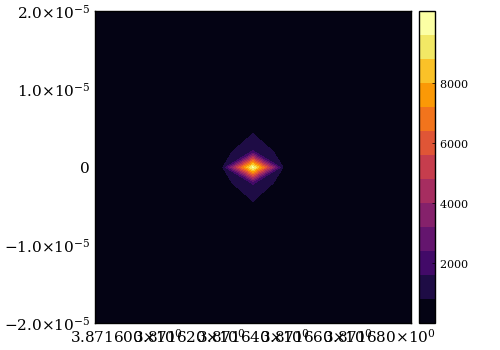

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [61]:
let Ev=collect(mDn+mDsn-100e-6:10e-6:mDn+mDsn),Γv=collect(-20e-6:2e-6:20e-6)
    resv=[1/abs(detVG(e+im*γ;C=-1,Λ=0.35,Cv=0.7,Cp=0.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

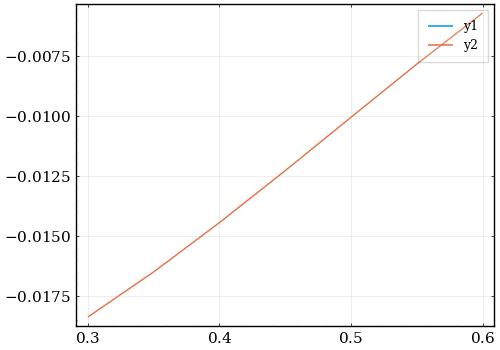

In [62]:
let Λv=0.3:0.05:0.6
    resv_rs1=[find_poles([1,λ,0.0,0.0];C=-1) for λ in Λv]
    resv_rs2=[find_poles([2,λ,0.0,0.0];C=-1) for λ in Λv]
    plot(Λv,real.(resv_rs1))
    plot!(Λv,real.(resv_rs2))
end

In [66]:
let Λv=collect(0.3:0.05:0.6),Cv_v=collect(0.0:0.1:1.0)
    global poles_rs1_CM=[find_poles([1,λ,c,0.0];C=-1) for c in Cv_v,λ in Λv]
    global poles_rs2_CM=[find_poles([2,λ,c,0.0];C=-1) for c in Cv_v,λ in Λv]
end

11×7 Matrix{ComplexF64}:
   -0.0183898-5.16062e-18im  …    -0.0056931-4.23898e-18im
   -0.0144605-9.40824e-19im     -0.000475879-3.59509e-19im
   -0.0109075+3.02703e-18im              NaN+NaN*im
  -0.00782811-1.56128e-18im              NaN+NaN*im
  -0.00526749+9.32686e-20im              NaN+NaN*im
  -0.00323995+1.41339e-18im  …           NaN+NaN*im
  -0.00173946+1.34033e-18im              NaN+NaN*im
 -0.000738565+1.10595e-18im              NaN+NaN*im
 -0.000183883+9.46158e-19im              NaN+NaN*im
  -9.99367e-7+1.2589e-12im               NaN+NaN*im
          NaN+NaN*im         …           NaN+NaN*im

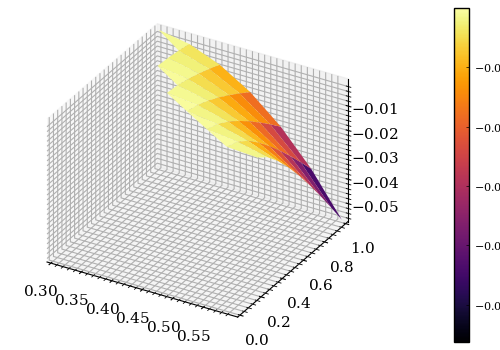

In [67]:
surface(0.3:0.05:0.6,0.0:0.1:1.0,real.(poles_rs1_CM))

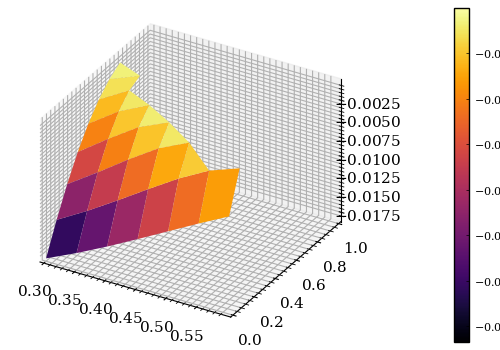

In [68]:
surface(0.3:0.05:0.6,0.0:0.1:1.0,real.(poles_rs2_CM))

In [69]:
isplus([1,0.4,1.0,0.0];C=-1)

1

In [71]:
isplus([2,0.4,0.2,0.0];C=-1)

1

In [72]:
find_poles([1,0.4,1.0,0.0];C=-1)

-0.007199951283154871 + 6.397617728236371e-19im

In [73]:
find_poles([1,0.4,1.0,0.0];C=1)

-0.0007291298110758682 - 6.50341205283915e-20im

# Parameters from Tcc+

In [16]:
df_tcc_cv=DataFrame(CSV.File("./output/tcc_cv.csv", header = ["x", "y","z"]))

Row,x,y,z
,Float64,Float64,Float64
1,0.396146,0.0,0.0
2,0.415655,0.1,0.0
3,0.441385,0.2,0.0
4,0.472925,0.3,0.0
5,0.513466,0.4,0.0
6,0.574052,0.5,0.0
7,0.668242,0.6,0.0
8,1.14731,0.7,0.0


## C=+

In [17]:
for i in 1:8
    find_poles([1,df_tcc_cv.x[i],df_tcc_cv.y[i],df_tcc_cv.z[i]])|>println
end

-0.019562680610435645 + 3.9888601624959124e-18im
-0.020918552189558515 + 2.993791880082503e-18im
-0.023069129589412984 + 1.0441862411820407e-18im
-0.02572838118840881 + 5.940031388221801e-18im
-0.02915972516833243 + 4.7577407693047994e-18im
-0.03463684481902041 + 4.0311416030823625e-18im
-0.04218518075844946 - 5.189132336880525e-18im
-0.06257333147664479 - 2.168813995644735e-17im


In [18]:
for i in 1:8
    find_poles([2,df_tcc_cv.x[i],df_tcc_cv.y[i],df_tcc_cv.z[i]])|>println
end

NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im


## C=-

In [19]:
for i in 1:8
    find_poles([1,df_tcc_cv.x[i],df_tcc_cv.y[i],df_tcc_cv.z[i]];C=-1)|>println
end

NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
-0.0025184076082651607 + 6.0735592223896095e-19im
-0.012505782363679163 + 1.534509203158821e-18im
-0.038714977724652044 + 9.049579601852363e-18im
-0.35955669546162294 + 8.10545247634627e-17im


In [20]:
for i in 1:8
    find_poles([2,df_tcc_cv.x[i],df_tcc_cv.y[i],df_tcc_cv.z[i]];C=-1)|>println
end

-0.014610410759015924 + 6.3410238002219875e-18im
-0.008654792502476916 - 3.1389831481089676e-18im
-0.0029883111889086322 - 7.268917283549773e-19im
-1.5808851060228335e-5 - 1.083641465514984e-11im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im
NaN + NaN*im


In [1]:
mJψ

LoadError: UndefVarError: mJψ not defined